# Importing libraries

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, BatchNormalization, Lambda, Dense, 
                                     Bidirectional, LSTM)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Data exploration

### Loading data

In [205]:
# Path to the folder
folder_path = "Data"

# Get all .png, .jpeg, and .jpg files in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".png")])
text_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".gt.txt")])

In [ ]:
total_intensities = defaultdict(int)

# Load images
images = []
data_labels = []
for index, file in enumerate(image_files):

    image_path = os.path.join(folder_path, image_files[index])
    text_path = os.path.join(folder_path, text_files[index]) 

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image using cv2

    if image is not None:
        images.append(image)
        
        # Append pixel intensities of the image
        pixel_intensities = image.flatten()
        for pixel in pixel_intensities:
            total_intensities[pixel] += 1
            
    with open(text_path, "r") as text_file:
        label = text_file.read()
    data_labels.append(label)

print(f"Loaded {len(images)} images with extensions .png, .jpeg, or .jpg.")


Loaded 3722 images with extensions .png, .jpeg, or .jpg.


In [206]:
# Find the longest string
longest_label = max(data_labels, key=len)
max_label_length = len(longest_label)
print("Longest label:", max_label_length )


Longest label: 10


In [207]:
# Convert the defaultdict to a standard dictionary
pixel_intensity_dict = dict(total_intensities)

# Prepare data for plotting
intensities = list(pixel_intensity_dict.keys())
frequencies = list(pixel_intensity_dict.values())

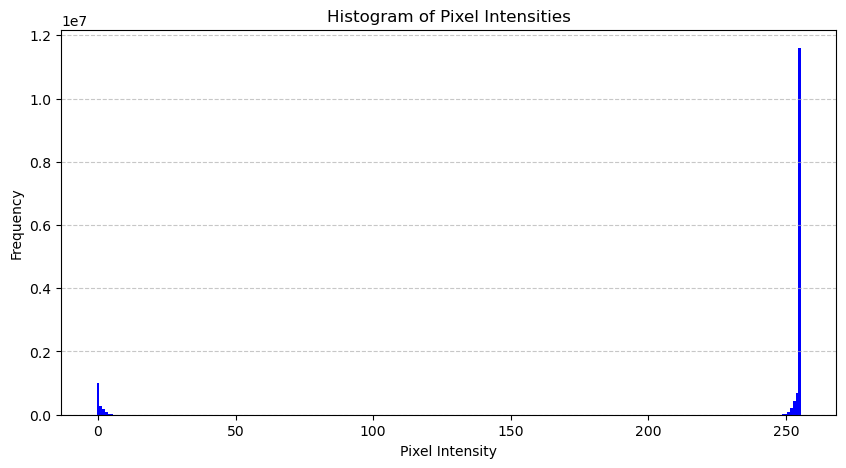

In [208]:
# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(intensities, frequencies, color='blue', width=1)
plt.title("Histogram of Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Inspecting intensity values

In [209]:
for intensity, frequency in sorted(total_intensities.items()):
    print(f"Pixel Intensity: {intensity}, Frequency: {frequency}")

Pixel Intensity: 0, Frequency: 1010106
Pixel Intensity: 1, Frequency: 265757
Pixel Intensity: 2, Frequency: 169230
Pixel Intensity: 3, Frequency: 83830
Pixel Intensity: 4, Frequency: 33193
Pixel Intensity: 5, Frequency: 10731
Pixel Intensity: 6, Frequency: 2767
Pixel Intensity: 7, Frequency: 570
Pixel Intensity: 8, Frequency: 105
Pixel Intensity: 9, Frequency: 10
Pixel Intensity: 10, Frequency: 1
Pixel Intensity: 246, Frequency: 16
Pixel Intensity: 247, Frequency: 124
Pixel Intensity: 248, Frequency: 2592
Pixel Intensity: 249, Frequency: 7120
Pixel Intensity: 250, Frequency: 30539
Pixel Intensity: 251, Frequency: 81490
Pixel Intensity: 252, Frequency: 204683
Pixel Intensity: 253, Frequency: 422029
Pixel Intensity: 254, Frequency: 687780
Pixel Intensity: 255, Frequency: 11597004


# Preprocessing 

### We can assume everything with a value of 10 or below is black, and everything with a value of 246 and above is white

In [8]:
for i in range(len(images)):
    _, thresholded_image = cv2.threshold(images[i], 245, 255, cv2.THRESH_BINARY)
    images[i] = thresholded_image 


In [9]:
total_intensities = defaultdict(int)
for image in images:
    pixel_intensities = image.flatten()
    for pixel in pixel_intensities:
        total_intensities[pixel] += 1

### Normalizing by dividing /255 to only allow 0 and 1

In [154]:
def normalize_image(image_list, target_size=(140, 40)):
    images = np.array([np.expand_dims(cv2.resize(image, target_size), axis=-1) for image in image_list])
    images = images / 255.0  # Normalize to [0, 1]
    return images
normalized_images = normalize_image(images)

### Encoding labels and padding them to the maximum length [10]

In [210]:
char_set = set(''.join(data_labels))
char_encoder = LabelEncoder()
char_encoder.fit(list(char_set))

np.save('classes.npy', char_encoder.classes_)

# Convert each label to a sequence of integers (character indices)
encoded_labels = [char_encoder.transform(list(label)) for label in data_labels]
padded_labels = pad_sequences(encoded_labels, padding='post', maxlen=10, value= len(char_set))

# Preparing the dataframe

In [213]:
df = pd.DataFrame(columns=["image", "label", "encoded_labels", "padded_labels"], data=zip(normalized_images, data_labels, encoded_labels, padded_labels))
df['input_length'] = 32
df["label_length"] = df["encoded_labels"].apply(len)

In [214]:
df.head(5)

,image,label,encoded_labels,padded_labels,input_length,label_length
0,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...",ءارسا,"[1, 6, 15, 17, 6]","[1, 6, 15, 17, 6, 35, 35, 35, 35, 35]",32,5
1,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...",فيرش,"[25, 34, 15, 18]","[25, 34, 15, 18, 35, 35, 35, 35, 35, 35]",32,4
2,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...",ءامسا,"[1, 6, 29, 17, 6]","[1, 6, 29, 17, 6, 35, 35, 35, 35, 35]",32,5
3,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...",مالسا,"[29, 6, 28, 17, 6]","[29, 6, 28, 17, 6, 35, 35, 35, 35, 35]",32,5
4,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...",رمع,"[15, 29, 23]","[15, 29, 23, 35, 35, 35, 35, 35, 35, 35]",32,3


In [216]:
# Inspecting the dataframe to make sure all values are present
print(df.isna().sum())

image             0
label             0
encoded_labels    0
padded_labels     0
input_length      0
label_length      0
dtype: int64


# Training the model

## Defining the model architecture

In [217]:
# input with shape of height=40 and width=140 
inputs = Input(shape=(40,140,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_set)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [218]:
act_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 40, 140, 1)]      0         
                                                                 
 conv2d_42 (Conv2D)          (None, 40, 140, 64)       640       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 20, 70, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 20, 70, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 10, 35, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 10, 35, 256)       295

### Defining the CTC loss function

In [219]:
labels = Input(name='the_labels', shape=[max_label_length], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64') 

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [220]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='min')
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', cooldown=0,min_lr=0.000000001)
csv = CSVLogger('trainingLossLogFile.csv')
callbacks_list = [checkpoint, early, lr, csv]

### Input length must be < 34 which is the Dense layer's dimension and the performance is the same for width 40 and width 33

In [ ]:
df['input_length'] = 33
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


# Extract the necessary variables from the training and test DataFrames
training_img = np.array(train_df['image'].values.tolist())
train_padded_txt = np.array(train_df['padded_labels'].values.tolist())
train_input_length = np.array(train_df['input_length'].values.tolist())
train_label_length = np.array(train_df['label_length'].values.tolist())

test_img = np.array(test_df['image'].values.tolist())
test_padded_txt = np.array(test_df['padded_labels'].values.tolist())
test_input_length = np.array(test_df['input_length'].values.tolist())
test_label_length = np.array(test_df['label_length'].values.tolist())

### Training the model

In [54]:
batch_size = 256
epochs = 10
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([test_img, test_padded_txt, test_input_length, test_label_length], [np.zeros(len(test_img))]), verbose = 1, callbacks = callbacks_list)


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 27.4433
Epoch 1: val_loss improved from inf to 14.14427, saving model to old_weights.hdf5


d:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 83s 6s/step - loss: 27.4433 - val_loss: 14.1443 - lr: 0.0010
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 13.7873
Epoch 2: val_loss improved from 14.14427 to 13.64011, saving model to old_weights.hdf5
12/12 [==============================] - 78s 7s/step - loss: 13.7873 - val_loss: 13.6401 - lr: 0.0010
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 13.2067
Epoch 3: val_loss did not improve from 13.64011
12/12 [==============================] - 73s 6s/step - loss: 13.2067 - val_loss: 13.7626 - lr: 0.0010
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 12.8969
Epoch 4: val_loss did not improve from 13.64011
12/12 [==============================] - 73s 6s/step - loss: 12.8969 - val_loss: 13.9026 - lr: 0.0010
Epoch 5/10
12/12 [==============================] - ETA: 0s - loss: 12.7254
Epoch 5: val_loss did not improve from 13.64011
12/12 [==============================] - 74s 6s/step - lo

## Loading the weights and testing the model

In [171]:
act_model.load_weights("./djangoapp/api/model/model_weights/working_old_weights.hdf5")

In [188]:
predict = normalized_images[0]
inputsss = np.array(predict)

In [199]:
print(normalized_images[0].shape)

(40, 140, 1)


In [197]:
prediction = act_model.predict(np.expand_dims(normalized_images[0], axis=0))  # This adds the batch dimension
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
greedy=True)[0][0])

1/1 [==============================] - 0s 46ms/step


In [200]:
i = 0
for x in out:
    print("original_text =  ", char_encoder.inverse_transform(df['encoded_labels'][i]))
    print("predicted text = ", end = '')
    x  = [y for y in x if y != -1]
    decoded_sequence = char_encoder.inverse_transform(x)
    print(decoded_sequence)
    print('\n')
    i+=1

original_text =   ['ء' 'ا' 'ر' 'س' 'ا']
predicted text = ['ى' 'ا' 'ب' 'ا']




## Since the training data is limited, it's better to train using cross-validation